# Tutorial: Cross-Validation and Anomaly Detection

Welcome to our tutorial on the **A**nomaly and **C**ommunity **D**etection (ACD) method. This is a 
probabilistic
 generative model and efficient algorithm to model anomalous edges in networks. It assigns latent variables as community memberships to nodes and anomaly to the edges.

In this tutorial, we will demonstrate how to use the ACD method. We will start by loading the data, performing cross-validation using the `model_selection` submodule, and then analyzing the results to determine the best number of communities \(K\).

## Setting the Logger
Let's first set the logging level to `DEBUG` so we can see the relevant messages.

In [1]:
# Set logging level to DEBUG
import logging

# Make it be set to DEBUG
logging.basicConfig(level=logging.DEBUG)
logging.getLogger("matplotlib").setLevel(logging.WARNING)

## Loading and Visualizing the Data

In this section, we will load the synthetic data required for our analyses. We will start by 
importing the necessary libraries and defining the file path for the adjacency matrix, and then, 
we will use the `import_data` method to read it.

In [2]:
# Step 1: Load the Data
from pgm.input.loader import build_adjacency_and_incidence_from_file

from importlib.resources import files

# Import necessary libraries
import pandas as pd

# Define the adjacency file
adj_file = "network_with_anomalies.csv"

# Load the network data
with files("pgm.data.input").joinpath(adj_file).open("rb") as network:
    graph_data = build_adjacency_and_incidence_from_file(network.name, header=0)

DEBUG:root:Read adjacency file from /home/dtheuerkauf/software-workshop/prob-gen-model-for-nets/pgm/data/input/network_with_anomalies.csv. The shape of the data is (2698, 3).
DEBUG:root:Creating the network ...
DEBUG:root:Removing self loops
INFO:root:Number of nodes = 300
INFO:root:Number of layers = 1
INFO:root:Number of edges and average degree in each layer:
INFO:root:E[0] = 2698 - <k> = 17.99
INFO:root:Sparsity [0] = 0.030
INFO:root:Reciprocity (networkX) = 0.201
INFO:root:Reciprocity (considering the weights of the edges) = 0.201


As we have seen in previous tutorials, the `import_data` outputs a list of MultiDiGraph NetworkX 
objects, a graph adjacency tensor `B`, a transposed graph adjacency tensor `B_T`, and
 an array with values of entries `A[j, i]` given non-zero entry `(i, j)`. These outputs are 
 essential for analyzing the network structure and performing further computations. 
 
Now that we have loaded the data, we can proceed to visualize the network structure.

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# Extract the graph list
A = graph_data.graph_list

# Set the seed for the layout
pos = nx.spring_layout(A[0], seed=42)

# Draw the graph using the spring layout
plt.figure(figsize=(5, 5))
nx.draw(
    A[0],
    pos=pos,
    node_size=50,
    node_color="black",
    alpha=0.6,
    edge_color="gray",
    with_labels=False,
)
plt.show()

## Performing the Cross-Validation

As we can see from the plot, there's no clear clustering. However, we can use the 
`AnomalyCommunityDetection` algorithm to infer the communities, and also to get some 
information about the anomalies. To do this, we need to specify a set of parameters related to the number of communities, their interrelations, and other structural aspects. Selecting the appropriate hyperparameters can be challenging, so we will utilize the `model_selection` module, which is designed for model selection and cross-validation to optimize the algorithm's performance. 

The `model_selection` module not only provides a comprehensive set of tools for model selection and cross-validation but also enables us to build specific modules for each model that carry out the cross-validation process. This module includes several submodules, each tailored for specific tasks:

- `parameter_search`: Functions for searching optimal model parameters.
- `cross_validation`: Functions for general cross-validation.
- `masking`: Functions for masking data during cross-validation.
- `labeling`: Functions for labeling data.
- `metrics`: Functions for computing evaluation metrics.
- `main`: Entry point for the cross-validation process. Although each algorithm has its own cross-validation submodule, the `main` submodule provides a unified interface for running cross-validation for all algorithms.

Additionally, the module provides specialized cross-validation submodules for different algorithms:
- `mtcov_cross_validation`: Cross-validation specific to the MTCOV algorithm.
- `dyncrep_cross_validation`: Cross-validation specific to the DynCRep algorithm.
- `acd_cross_validation`: Cross-validation specific to the ACD algorithm.
- `crep_cross_validation`: Cross-validation specific to the CRep algorithm.
- `jointcrep_cross_validation`: Cross-validation specific to the JointCRep algorithm.

By leveraging these tools, we can systematically assess and fine-tune our model to achieve the best possible results.

Let's look now at how to use it. As mentioned, we will use the `main` submodule to perform 
cross-validation for the ACD method. To do that, we need to define the model parameters 
(`model_parameters`) and cross-validation parameters (`cv_params`). The `model_parameters` 
include the lists of hyperparameters of the ACD method we would like to test. The `cv_params` 
include the parameters for the cross-validation process, such as the number of folds, the input 
folder, and the output results. Optionally, we can also specify another dictionary 
(`numerical_parameters`) with the 
numerical parameters to run the inference algorithm, like the number of iterations or the 
convergence threshold. We will set the number of iterations to 1000 using this input dictionary.

In [10]:
# Step 2: Perform Cross-Validation
fold_number = 3
# Define the cross-validation parameters
model_parameters = {
    "K": [2, 3],
    "flag_anomaly": True,
    "rseed": 10,
    "initialization": 0,
    "out_inference": False,
    "out_folder": "outputs/" + str(fold_number) + "-fold_cv/",
    "end_file": "_ACD",
    "assortative": True,
    "undirected": False,
    "files": "../data/input/theta.npz",
}
cv_params = {
    "in_folder": "../../../pgm/data/input/",
    "adj": adj_file,
    "ego": "source",
    "alter": "target",
    "NFold": fold_number,
    "out_results": True,
    "out_mask": False,
    "sep": " ",
}
numerical_parameters = {
    "max_iter": 1000,
    "num_realizations": 1,
}

As we can see, the `model_parameters` dictionary contains the hyperparameters we want to test. In
 this case, we will only focus on the number of communities `K`. To avoid making the tutorial too long, we will only test two values for `K`, but in practice, we should test a broader range of values. 
 
We are now ready to run the cross-validation process. We will use the `cross_validation` function from the `main` submodule, passing the method name (`ACD`), the model parameters, and the cross-validation parameters as arguments. The function will then perform the cross-validation and store the results in a CSV file.

In [11]:
from pathlib import Path

# Define the output file name
adj_file_stem = Path(adj_file).stem
cv_results_file = Path(f"outputs/{fold_number}-fold_cv/{adj_file_stem}_cv.csv")

# Delete the file if it already exists
if cv_results_file.exists():
    cv_results_file.unlink()

# Run the cross-validation
from pgm.model_selection.main import cross_validation

results = cross_validation("ACD", model_parameters, cv_params, numerical_parameters)

INFO:root:Starting cross-validation for algorithm: ACD
DEBUG:root:Converting parameter flag_anomaly to list. The value used is True
DEBUG:root:Converting parameter rseed to list. The value used is 10
DEBUG:root:Converting parameter initialization to list. The value used is 0
DEBUG:root:Converting parameter out_inference to list. The value used is False
DEBUG:root:Converting parameter out_folder to list. The value used is outputs/3-fold_cv/
DEBUG:root:Converting parameter end_file to list. The value used is _ACD
DEBUG:root:Converting parameter assortative to list. The value used is True
DEBUG:root:Converting parameter undirected to list. The value used is False
DEBUG:root:Converting parameter files to list. The value used is ../data/input/theta.npz
INFO:root:Parameter grid created with 2 combinations
INFO:root:Running cross-validation for parameters: {'K': 2, 'flag_anomaly': True, 'rseed': 10, 'initialization': 0, 'out_inference': False, 'out_folder': 'outputs/3-fold_cv/', 'end_file': '

## Loading the Cross-Validation Results

Now we are ready to load the cross-validation results into a DataFrame and analyze them to determine the best number of communities \(K\). We will load the results from the CSV file generated during the cross-validation process and display the first few rows to get an overview of the data.

In [12]:
# Step 3: Load the Cross-Validation Results

# Load the cross-validation results into a DataFrame
adj_file_stem = adj_file.split(".")[0]
cv_results_file = "outputs/" + str(fold_number) + f"-fold_cv/{adj_file_stem}_cv.csv"
cv_results = pd.read_csv(cv_results_file)

# Display the cross-validation results
cv_results

,K,fold,rseed,flag_anomaly,mu,pi,ELBO,final_it,aucA_train,aucA_test
0,2,0,265,True,0.482160,0.003595,-10952.354486,551,0.868516,0.694000
1,2,1,265,True,0.490233,0.003594,-11116.213476,291,0.873517,0.693991
2,2,2,265,True,0.484847,0.003967,-11186.622153,241,0.863744,0.699252
3,3,0,265,True,0.552818,0.002587,-12016.591568,161,0.924452,0.804518
4,3,1,265,True,0.559593,0.002336,-12141.210693,131,0.934237,0.810586
5,3,2,265,True,0.555133,0.002499,-12204.589153,261,0.929155,0.800536


As we can see, the resulting dataframe shows information about the used data folds, the 
number of communities, the random seed, the anomaly flag, the parameters `mu` and `pi`, the 
ELBO score, and the number of iterations needed to reach convergence of the ELBO function. 
Moreover, we can also see the scores for each combination of parameters both on the folds used 
for training, and the folds used for testing. Since we are interested in determining the best `K` 
value (best in terms of AUC scores over the folds), we will group the results by `K` and calculate 
the mean score for each group.

In [13]:
# Remove the specified columns
cv_results_filtered = cv_results.drop(
    columns=["fold", "rseed", "flag_anomaly", "final_it", "mu", "ELBO", "pi"]
)

# Group by 'K' and calculate the mean for each group
cv_results_mean = cv_results_filtered.groupby("K").mean().reset_index()
cv_results_mean

,K,aucA_train,aucA_test
0,2,0.868593,0.695747
1,3,0.929281,0.805213


Now it is evident that `K` equal to 3 is the best choice, as it has the highest mean score (both 
in training and testing). We will use it to run the algorithm with the whole dataset, and 
then analyze the results.

In [14]:
# Get the best K
best_K = cv_results_mean.loc[cv_results_mean["aucA_test"].idxmax()]["K"]
# Turn K into an integer
best_K = int(best_K)
best_K

3

## Run the algorithm with the best K

First, we instantiate the model with the previously used numerical parameters, and then we run 
it with the best `K` value.

In [15]:
from pgm.model.acd import AnomalyDetection

model = AnomalyDetection()

inferred_parameters = model.fit(
    graph_data,
    K=best_K,
    flag_anomaly=model_parameters["flag_anomaly"][0],
    rseed=model_parameters["rseed"][0],
    initialization=model_parameters["initialization"][0],
    out_inference=model_parameters["out_inference"][0],
    assortative=model_parameters["assortative"][0],
    undirected=model_parameters["undirected"][0],
)

DEBUG:root:Fixing random seed to: 10
DEBUG:root:Preprocessing the data for fitting the model.
DEBUG:root:Data looks like: [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]
DEBUG:root:Random number generator seed: 10
DEBUG:root:u, v and w are initialized randomly.
DEBUG:root:Updating realization 0 ...
DEBUG:root:num. realization = 0 - iterations = 100 - time = 2.82 seconds
DEBUG:root:num. realizations = 0 - ELBO = -15522.747909433549 - ELBOmax = -15522.747909433549 - iterations = 111 - time = 3.06 seconds - convergence = True
DEBUG:root:Best real = 0 - maxL = -15522.747909433549 - best iterations = 111
DEBUG:root:Parameters won't be saved! If you want to save them, set out_inference=True.


In [16]:
u, v, w, mu, pi, _ = inferred_parameters

In [17]:
# Print the shape of each parameter
print("u shape: ", u.shape)
print("v shape: ", v.shape)
print("w shape: ", w.shape)
print("mu: ", mu)
print("pi: ", pi)

u shape:  (300, 3)
v shape:  (300, 3)
w shape:  (1, 3)
mu:  0.5613593192719294
pi:  0.006983211971017939


## Community Detection

Now that we have run the algorithm with the best `K` value, we can analyze the results. We will 
first plot the adjacency matrix to confirm that our choice of `K` was correct. 

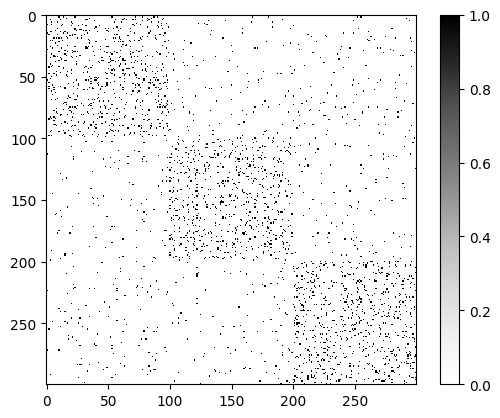

In [18]:
# Create a graph from the first adjacency matrix in the list A
graph = A[0]

# Get the adjacency matrix
adjacency_matrix = nx.adjacency_matrix(graph)

# Plot the adjacency matrix
plt.imshow(adjacency_matrix.toarray(), cmap="Greys", interpolation="none")

# Add a color bar to the plot for reference
plt.colorbar()
plt.show()

It is now more evident that the input data has indeed three communities, which matches the 
results given by the cross validation. 

We can now use the inferred parameters to plot the graph together with the communities.

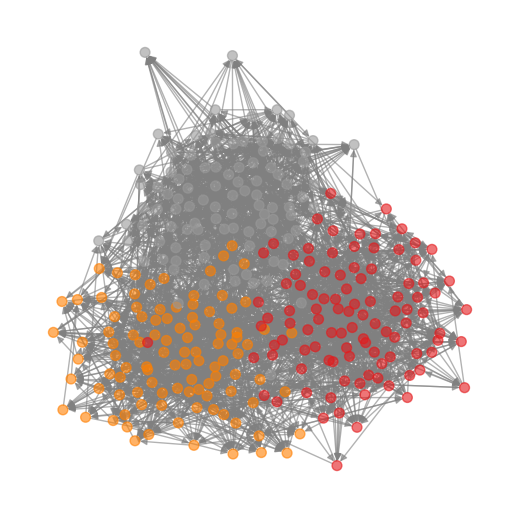

In [19]:
import numpy as np

# Get the community with the highest probability for each node
umax = np.argmax(u, 1)

# Draw the graph using the spring layout
plt.figure(figsize=(5, 5))
nx.draw(
    A[0],
    pos=pos,
    node_size=50,
    node_color=umax,
    alpha=0.6,
    edge_color="gray",
    with_labels=False,
    cmap=plt.cm.Set1,
)
plt.show()

## Anomaly Detection

As we have seen, the `ACD` method also provides information about the anomalies. We can use the 
inferred parameters `pi` and `mu` to build a matrix `Q` that represents the probability of each 
edge being an anomaly. We can then set a threshold to determine which edges are anomalous. We can
 decide which threshold to use based on the distribution of values in `Q`.

Text(0.5, 1.0, 'Q distribution')

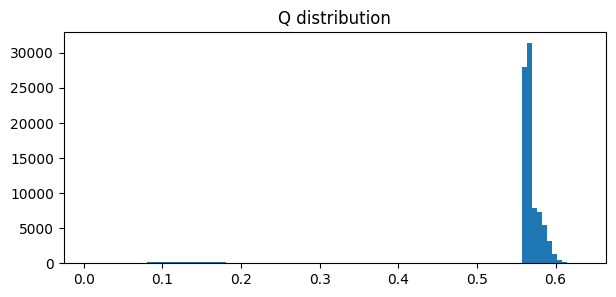

In [20]:
from pgm.output.evaluate import lambda0_full, calculate_Q_dense

# Calculate the matrix Q
M0 = lambda0_full(u, v, w)
Q = calculate_Q_dense(graph_data.incidence_tensor, M0, pi, mu)

# Plot the distribution of values in Q
fig = plt.figure(figsize=(7, 3))
plt.hist(Q[0].flatten(), bins=100)
plt.title("Q distribution")

The distribution of values in Q is skewed, with most values close to 0.6. We can concentrate on the most anomalous values by selecting the top 10%.

In [16]:
import numpy as np

Text(0.5, 1.0, 'Z_pred')

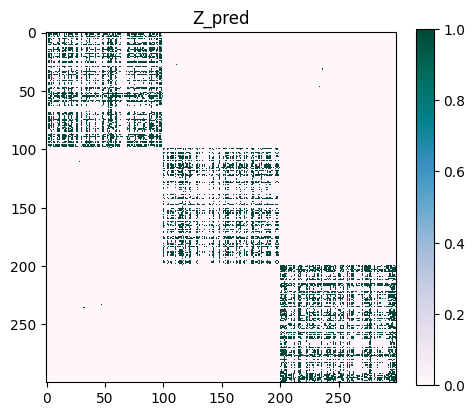

In [21]:
# Calculate the threshold for the top 10% most anomalous edges
threshold = np.percentile(Q[0].flatten(), 90)

# Create a copy of Q and set the top 10% most anomalous edges to 1, and the rest to 0
Z_pred = np.copy(Q[0])
Z_pred[Q[0] >= threshold] = 1
Z_pred[Q[0] < threshold] = 0

plt.figure(figsize=(5, 5))
cmap = "PuBuGn"
plt.imshow(Z_pred, cmap=cmap, interpolation="none")
plt.colorbar(fraction=0.046)
plt.title("Z_pred")

### Summary

In this notebook, we explored the **Anomaly and Community Detection (ACD)** model. We began by loading and visualizing the data after importing the necessary libraries. Next, we performed cross-validation by defining both model and cross-validation parameters, using the `cross_validation` function from the `model_selection` module. The results were then loaded to identify the optimal number of communities \(K\) based on the AUC scores.

With the best \(K\) value determined, we proceeded by running the ACD algorithm. For community detection, we validated the choice of \(K\) by plotting the adjacency matrix and visualizing the graph with the detected communities.

For anomaly detection, we computed the matrix \(Q\), which represented the probability of each edge being an anomaly.

## References
[1] Safdari, H., De Bacco, C. Anomaly detection and community detection in networks. J Big Data 9, 122 (2022). 